# Challenge Tier - III
## Quantum Machine Learning

### Introduction
Machine Learning has been the buzz word for the past few years and the reason being the development of the better algorithms and the increase in the computation power over these years. Also, in the field of quantum computing there are algorithms known as Variational algorithms, which are based on optimizing the parameters of a circuit, using a classical control.These also have applications in quantum computing and especially in the area of Quantum Machine Learning(QML).

### What is Machine Learning?
Machine Learning is a system of computer algorithms that can learn from example through self-improvement without being explicitly coded by a programmer. Machine learning is a part of artificial Intelligence which combines data with statistical tools to predict an output which can be used to make actionable insights.
The basic premise of machine learning is to build algorithms that can receive input data and use statistical analysis to predict an output while updating outputs as new data becomes available.

These days there are lot of available libraries that provide you with the algorithms which you may directly use for the ML problems. They require an appropriate choice of the algorithm to be used, dataset to be analyzed and it returns with a model, which you may use.

### Why is there a need of QML?
The classical Machine Learning problem has two major limitations:
1. The classical ML lagos might be slow and might get affected by the huge amount of training data. The training time required for the best algorithms available would be high, when the volume of data is huge. If this data is quantum in nature, the quantum computer can outrun the classical computers.
2. The second limitation is that for increasing the degrees of freedom the number of classical bits should also increase accordingly. This can be tackled by using the quantum property of superposition. Using superposition we can encode more information efficiently and thus giving us a better result with fewer resources.

## Problem
#### (This is an open-ended problem)
The main aim of the challenge is to play with QML models, and use them for various classification tasks on classical datasets.

There are three stages in a QML circuit:
1. Encoding/Embedding the data
2. Parameterized Quantum Circuits and measurement
3. Optimizing the parameters using classical optimizer

There can be alterations to the 3-stage structure too, and various approaches with the embedding of data.

### Task 1(Tutorial)
Classification task on the existing Iris dataset [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris), using the QML methods described in the tutorial we will classify the Iris dataset.
You may follow this [tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html#id3), so that you yourselves acquianted with the implementation of a QML model on a real world dataset.
##### NOTE:
You need to experiment with various different circuits (any stage encoding/PQC) other than the ones given in the tutorial, and you have to submit the various findings for the same dataset(Iris).  
##### BONUS :  if you showcase your findings using graphs, curves and various metrics.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dev = qml.device('default.qubit', wires=2)

# Amplitude Encoding

In [3]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


In [4]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [5]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 5.38967743e-01  7.95036065e-01  2.78265032e-01 -2.77555756e-17]


In [6]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [7]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [8]:
def variational_classifier(var, angles):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles) + bias

In [9]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [10]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [11]:
def cost(weights, features, labels):
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

In [12]:
data = np.loadtxt("./data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print("First X sample (original)  :", X[0])

# pad the vectors to size 2^2 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.3  0.  ]
First X sample (normalized): [0.44376016 0.83205029 0.33282012 0.        ]
First features sample      : [ 0.67858523 -0.          0.         -1.080839    1.080839  ]


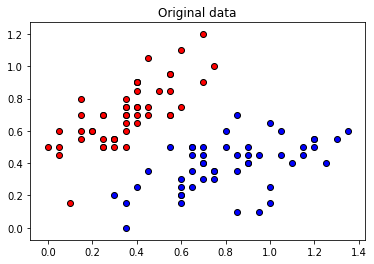

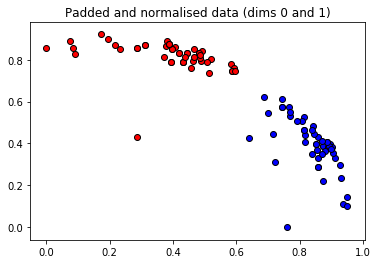

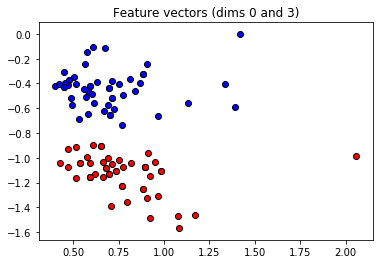

In [13]:
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

In [14]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [15]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)

In [17]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.4336454 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.2773742 | Acc train: 0.4933333 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.0847459 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.9640221 | Acc train: 0.5066667 | Acc validation: 0.6000000 
Iter:     5 | Cost: 0.8758696 | Acc train: 0.6666667 | Acc validation: 0.7600000 
Iter:     6 | Cost: 0.8775241 | Acc train: 0.6933333 | Acc validation: 0.6400000 
Iter:     7 | Cost: 0.9676359 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     8 | Cost: 1.0387106 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 0.9913197 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 0.9600399 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 0.9408147 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 0.8647003 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    13 | Co

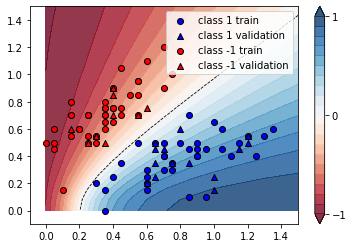

In [18]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 20), np.linspace(0.0, 1.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.3 * np.ones((len(X_grid), 1))
X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
normalization = np.sqrt(np.sum(X_grid ** 2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [variational_classifier(var, f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(
    xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
)
plt.contour(
    xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
)
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

### Task 2(Final Task)
There is another popular dataset prevalent in Computer Vision, which is the [MNIST Dataset](https://www.kaggle.com/c/digit-recognizer/data). This dataset is generally used to check the correctness of a CV model.This dataset is more difficult than the Iris dataset, since it has more classes and has a high dimensionality of 784.

Your task is to make a QML model to carry out the classification task for the MNIST Dataset and document your findings and steps, using minimum number of qubits. Present your findings along with proper documentation, graphs and explanation.